In [90]:
import mlp_explainer
from mlp_explainer import syndata, explainer, metrics
from sklearn import model_selection, preprocessing
from scikeras.wrappers import KerasClassifier
from tensorflow import keras
import numpy as np
import wandb
from wandb.integration.keras import WandbMetricsLogger

In [3]:
syn = syndata.SyntheticData('experiment_2', 'discrete')

In [4]:
syn.create_dataset(10000)

  0%|          | 0/8 [00:00<?, ?it/s]

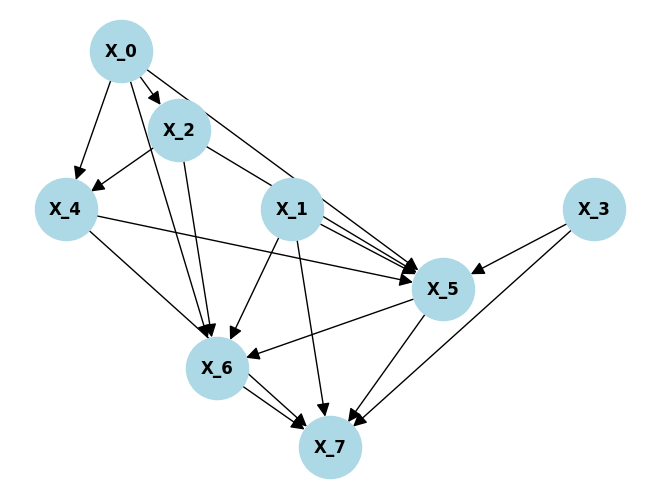

In [5]:
metrics.draw_network(syn.model)

In [81]:
target = 'X_5'

In [82]:
'''
Split Data.
'''

X = syn.dataset.drop(target, axis = 1).to_numpy()
Y = syn.dataset[target].to_numpy()

X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, Y, test_size = 0.2, random_state = 42, shuffle = True
)

In [83]:
def preprocessor(x):
    return x

X_train = preprocessor(X_train)
X_test = preprocessor(X_test)

In [92]:
wandb.login()

True

In [136]:
def build_model(n_layers = 5, n_nodes_l = 2, n_nodes_u = 10, optimizer = 'adam', learning_rate = 0.001):
    
    model = keras.Sequential()
    model.add(keras.Input(shape = (X_train.shape[1],)))
    for i in range(n_layers):
        model.add(keras.layers.Dense(np.random.choice([i for i in range(n_nodes_l, n_nodes_u)]), activation = np.random.choice(['relu', 'sigmoid'])))
    model.add(keras.layers.Dense(3, activation = 'softmax'))

    if optimizer == 'sgd':
        optim = keras.optimizers.SGD(learning_rate = learning_rate)
    elif optimizer == 'adam':
        optim = keras.optimizers.Adam(learning_rate = learning_rate)
    
    model.compile(optimizer = optim, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
    
    return model

In [134]:
n_layers = 8
n_nodes_l = 2
n_nodes_u = 25
optimizer = 'adam'
learning_rate = 0.01
epochs = 25
batch_size = 50

In [135]:
wandb.init(entity = "computer-vision-wits", project = "MLP-E", name = "")

model = build_model(
    n_layers = n_layers, 
    n_nodes_l = n_nodes_l,
    n_nodes_u = n_nodes_u, 
    optimizer = optimizer, 
    learning_rate = learning_rate
)

config = wandb.config
config.n_layers = n_layers
config.n_nodes_l = n_nodes_l
config.n_nodes_u = n_nodes_u
config.optimizer = optimizer
config.epochs = epochs
config.batch_size = batch_size
config.learning_rate = learning_rate
config.model = model
config.target = target

model.fit(X_train, y_train, epochs = epochs, batch_size = batch_size, validation_split = 0.1, callbacks = [WandbMetricsLogger()])
model.summary()

wandb.finish()

Epoch 1/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5083 - loss: 0.7133 - val_accuracy: 0.5163 - val_loss: 0.6937
Epoch 2/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5719 - loss: 0.6713 - val_accuracy: 0.6612 - val_loss: 0.6484
Epoch 3/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6671 - loss: 0.6310 - val_accuracy: 0.6775 - val_loss: 0.6224
Epoch 4/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6714 - loss: 0.6221 - val_accuracy: 0.6825 - val_loss: 0.6201
Epoch 5/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6790 - loss: 0.6150 - val_accuracy: 0.6825 - val_loss: 0.5985
Epoch 6/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6821 - loss: 0.6120 - val_accuracy: 0.6925 - val_loss: 0.5953
Epoch 7/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6842 - loss: 0.6111 - val_accuracy: 0.6925 - val_loss: 0.5950
Epoch 8/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6862 - loss: 0.6127 - val_accuracy: 0.

Model: "sequential_60"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_528 (Dense)               │ (None, 4)              │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_529 (Dense)               │ (None, 15)             │            75 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_530 (Dense)               │ (None, 24)             │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_531 (Dense)               │ (None, 2)              │            50 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_532 (Dense)               │ (None, 11)             │            33 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_533 (Dense)               │ (None, 9)              │           108 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_534 (Dense)               │ (None, 16)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_535 (Dense)               │ (None, 12)             │           204 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_536 (Dense)               │ (None, 3)              │            39 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,257 (12.73 KB)

 Trainable params: 1,085 (4.24 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,172 (8.49 KB)

epoch/accuracy,▁▃▇▇▇▇▇▇█████████████████
epoch/epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▆▇▇▇▇▇▇▇█████▇█▇████████
epoch/val_loss,█▅▄▄▂▂▂▂▃▂▂▁▁▂▂▁▂▁▁▁▁▁▂▁▁
epoch/accuracy,0.69625
epoch/epoch,24
epoch/learning_rate,0.01
epoch/loss,0.60262
epoch/val_accuracy,0.71625
